In [1]:
%load_ext autoreload
%autoreload 2
%cd C:\MAD4AG
%matplotlib inline

C:\MAD4AG


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import warnings

warnings.filterwarnings('ignore')

In [25]:
file_name = f'./dbs/intermediate/stops_1_new.parquet'

#Read each batchs file
df = pd.read_parquet(file_name)

In [4]:
print('The number of stops: ',len(df))
df = df[df.holiday_s != 1]
df = df[df.weekday_s == 1]
df = df.drop(['holiday_s', 'weekday_s'], axis=1)

print('The number of stops in weekday and non-holiday: ', len(df))


The number of stops:  28075949
The number of stops in weekday and non-holiday:  13060259


### repeat each row (stop) based on stay duration.
### e.g., if stay in a stop longer than 30 min, make two stops

In [5]:
df_stop = df.copy()

In [6]:
df_stop['dur_rp'] = (df_stop['dur'] / 30) + 1
df_stop['dur_rp'] = df_stop['dur_rp'].astype(int)

In [7]:
df_stop = pd.DataFrame(np.repeat(df_stop.values, df_stop['dur_rp'].tolist(), axis=0),  columns=df_stop.columns)

df_stop.drop(['dur_rp'],inplace=True, axis=1)

### grouping and auto increment in index based stay

In [8]:
df_stop['stay_seq'] = df_stop.groupby(['uid', 'seq']).cumcount()

In [9]:
df_stop['timestamp'] = pd.to_datetime(df_stop['localtime']) + (pd.Timedelta(minutes=30) * df_stop['stay_seq'])

In [10]:
df_stop['hour'] = df_stop['timestamp'].dt.hour

In [11]:
#Hours with higher than 0.8 frequency of being at home in the survey data.

nighthours = (0,1,2,3,4,5,6,7,19,20,21,22,23,24)


### number of visit for each cluster during night hours

In [12]:
df_night_visit = df_stop[['uid','cluster','localtime','hour']][df_stop.hour.isin(nighthours)]

df_night_visit['night_visits']= df_night_visit['localtime'].dt.strftime('%m-%d')

df_night_visit = df_night_visit.groupby(['uid','cluster'])['night_visits'].nunique().reset_index()

In [13]:
df_stop = pd.merge(df_stop, df_night_visit, on=['uid', 'cluster'], how='left')

### remove clusters having less than 3 night stay and 10 score


In [14]:
min_night_visit=3
min_score= 10
%store -r min_night_visit
%store -r min_score

df_h = df_stop[(df_stop.hour.isin(nighthours))&(df_stop.night_visits>=min_night_visit)]

df_h = df_h.groupby(['uid','cluster'])['dur'].agg(['sum','count']).reset_index()

df_h.rename({'count':'stops', 'sum':'total_duration' }, axis=1,inplace=True)

#df_h = df_h[df_h['total_duration'] >= 300]

### calculate score

In [15]:
def score_calculator(data):
    # represent points consistently as (lat, lon)
    #urban_density, hour = data[['urban_density','hour']].loc[0]
    batch = data[['urban_density','hour']].values[0]

    #print(coords[0])

    home_frequency = pd.read_csv('dbs/intermediate/act_temporal_pattern.csv', index_col='activity')
    home_frequency = home_frequency.loc['Home', :].values.tolist()

    data['score'] = home_frequency[batch[1]]

    return data

In [16]:
df_score= df_stop.copy()

df_score= df_score[['uid', 'cluster', 'hour', 'Deso']]

df_score['urban_density'] =df_score['Deso'].str[4]




In [17]:
tqdm.pandas()
df_score = df_score.groupby(['urban_density','hour']).progress_apply(score_calculator)

  0%|          | 0/72 [00:00<?, ?it/s]

In [18]:
df_score = df_score[df_score.hour.isin(nighthours)]
df_score = df_score.groupby(['uid','cluster'])['score'].sum().reset_index()


df_h = pd.merge(df_h, df_score[['uid','cluster','score']], on=['uid','cluster'], how='left')

df_h = df_h[df_h['score'] >= min_score]

In [19]:
# df_score= df_stop.copy()
#
# df_score['score'] = 0
#
# home_frequency = pd.read_csv('Master Thesis/Master Thesis Colab/DataFolder/Cag_activityTypefreBytime.csv')
#
# home_frequency = home_frequency.iloc[0, 1:25].values.tolist()
#
# for hour in range(0,24):
#     df_score['score'][df_score['hour']== hour] = home_frequency[hour]
#
# df_score = df_score[df_score.hour.isin(nighthours)]
# df_score = df_score.groupby(['uid','cluster'])['score'].sum().reset_index()
#
#
# df_h = pd.merge(df_h, df_score[['uid','cluster','score']], on=['uid','cluster'], how='left')
#
# df_h = df_h[df_h['score'] >= 10]

### sort the clusters by score and keep the two highest score clusters as potential home positions

In [20]:
df_h= df_h.sort_values(['uid','score'], ascending=False)


df_h = df_h.groupby('uid').head(2)


df_h = pd.merge(df_h, df_stop[['uid','cluster','ANDAMAL_1', 'distance']].drop_duplicates(), on=['uid','cluster'], how='left')
#df_h['ANDAMAL_1'].value_counts(normalize=True)

In [21]:
#If the distance to the nearest building is more than 200m, assign 0 to the building type.

df_h.ANDAMAL_1 = np.where(df_h['distance'] >= 0.2 , 0, df_h.ANDAMAL_1)


## Save the two highest score house

In [22]:

df_h.to_parquet(f'./dbs/intermediate/home_inference.parquet')

### Score distribution of inferred home locations

In [23]:
df_h_1 = df_h.groupby('uid').head(1)

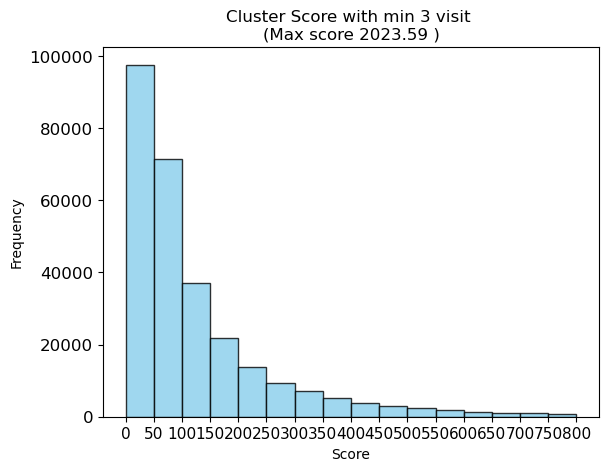

In [24]:
plt.hist(df_h_1['score'][df_h_1['score']<=800], bins=range(0,850,50), color='skyblue', edgecolor='black', alpha=0.8)

# Adding labels and title
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Cluster Score with min '+str(min_night_visit)+' visit \n'+"(Max score %.2f )"%(max(df_h_1['score'])))

x_labels = range(0,850,50)  # Generate labels from 1 to 24
x_ticks = range(0,850,50)  # Position the labels every other data point
#plt.ylim(0, 1.1)
plt.xticks(x_ticks, x_labels, fontsize=11)
plt.yticks(fontsize=12)
plt.savefig('figures/home_score_min_visit_'+str(min_night_visit)+'.png', dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

### Add building metadata to the extracted house location and show the distribution of building types

In [25]:
building_metadata = pd.read_csv(f'./dbs/building_purpose_codes.csv', encoding='ISO-8859-1', sep = ';')

In [26]:

home_dist = pd.DataFrame(df_h_1['ANDAMAL_1'].value_counts(normalize=True)*100).reset_index().rename(columns={'ANDAMAL_1':'share(%)'})
home_dist = pd.merge(home_dist, building_metadata, left_on='index', right_on='Code', how='left')

home_dist['Purpose of building'][home_dist['index']==0]='no_building'


home_dist = home_dist.groupby('Purpose of building')['share(%)'].sum().reset_index().sort_values(by=['share(%)'], ascending=False)

home_dist['share(%)'] = home_dist['share(%)'].round(2)


home_dist

,Purpose of building,share(%)
5,Residential,73.31
4,Public,9.98
0,Activity,7.89
6,no_building,3.28
2,Industrial,3.24
3,Other building,2.19
1,Agricultural,0.11


In [27]:
print("Data contains %s devices in weekdays-non holidays."%(len(df.uid.unique())))
print("The home location of %s devices was detected  (%s of all devices)."%(len(df_h_1.uid.unique()), (np.round(len(df_h_1.uid.unique())/len(df.uid.unique()), 4)*100)))
print("The home location of %s devices could not be detected."%(len(df.uid.unique())-len(df_h_1.uid.unique())))

Data contains 364666 devices in weekdays-non holidays.
The home location of 280996 devices was detected  (77.06 of all devices).
The home location of 83670 devices could not be detected.


### devices having  most likely two house location

In [28]:
df_h_two_house = df_h[df_h.duplicated(subset=['uid']) | df_h.duplicated(subset=['uid'], keep='last')]

df_h_two_house = df_h_two_house.sort_values(by=['uid', 'score'])

In [29]:
df_h_two_house['score_per_dif']= 0.0


percent_dif = pd.DataFrame(( 1- (df_h_two_house['score'].values[::2]/df_h_two_house['score'].values[1::2])) , columns=['percent_dif'])

df_h_two_house['score_per_dif'].values[::2] = percent_dif.percent_dif
df_h_two_house['score_per_dif'].values[1::2] = percent_dif.percent_dif


df_h_two_house = df_h_two_house[(df_h_two_house.score > 100)& (df_h_two_house.score_per_dif < 0.1)]


In [30]:
print("%s devices most likely have two home locations."%(len(df_h_two_house.uid.unique())))

1891 devices most likely have two home locations.
